# Исследование интернет-магазина. Проверка гипотез. Анализ A/B-теста

<a id="Начало_проекта"></a>

<div style="border:solid black 2px; padding: 20px">

Проведем исследование на данных интернет-магазина.

Вместе с отделом маркетинга подготовили список гипотез для увеличения выручки. 

**Цели исследования** 
* Приоритизировать гипотезы.
* Проанализировать графики кумулятивных данных. 
* Запустить A/B-тест.
* Проанализировать результаты A/B-теста.
* Принять решение по результатам A/B-теста.

**Ход исследования**

Данные о поведении пользователей получили из файлов:
* `/datasets/hypothesis.csv`
* `/datasets/orders.csv`
* `/datasets/visitors.csv`

О качестве данных нам ничего не известно. Поэтому перед проверкой гипотез проведем обзор данных. 

Таким образом, исследование пройдёт в несколько этапов:
1. [Загрузка и обзор данных](#загрузка)
2. [Предобработка данных](#предобработка)
3. [Приоритизация гипотез](#приоритизация)
4. [Проверка пользователей в разрезе групп](#проверка)
5. [Анализ A/B-теста](#анализ)
7. [Итоги исследования](#итоги)

**Описание данных**

Файл *hypothesis.csv*:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл *orders.csv*:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл *visitors.csv*:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

</div>

[Начало_проекта](#Начало_проекта)

<a id="загрузка"></a>

## Загрузка и обзор данных

<div style="border:solid black 2px; padding: 20px">

### Импортируем библиотеки. Считываем данные из csv-файлов и сохраняем в переменные

</div>

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
hypothesis = pd.read_csv('hypothesis.csv') 
orders = pd.read_csv('orders.csv') 
visitors = pd.read_csv('visitors.csv')

### Получим общую информацию о таблицах

In [3]:
def data_info(data):
    print('-'*50)
    print('Первые 5 строк таблицы')
    print('-'*50)
    display(data.head())
    print('-'*50)
    print('Общая информация о таблице')
    print('-'*50)
    data.info()
    print('-'*50)
    print('Основные статистические данные')
    print('-'*50)
    display(data.describe().T)
    print('-'*50)
    print('Подсчет пропусков')
    print('-'*50)
    display(data.isna().sum())
    print('-'*50)
    print('Проверка явных дубликатов')
    print('-'*50)
    print(data.duplicated().sum())

In [4]:
data_info(hypothesis)

--------------------------------------------------
Первые 5 строк таблицы
--------------------------------------------------


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


--------------------------------------------------
Общая информация о таблице
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
--------------------------------------------------
Основные статистические данные
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Reach,9.0,4.777778,3.153481,1.0,3.0,3.0,8.0,10.0
Impact,9.0,4.777778,3.192874,1.0,3.0,3.0,7.0,10.0
Confidence,9.0,5.555556,3.045944,1.0,3.0,7.0,8.0,9.0
Efforts,9.0,4.888889,2.803767,1.0,3.0,5.0,6.0,10.0


--------------------------------------------------
Подсчет пропусков
--------------------------------------------------


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

--------------------------------------------------
Проверка явных дубликатов
--------------------------------------------------
0


In [5]:
data_info(orders)

--------------------------------------------------
Первые 5 строк таблицы
--------------------------------------------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


--------------------------------------------------
Общая информация о таблице
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
--------------------------------------------------
Основные статистические данные
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
transactionId,1197.0,2.155621e+09,1.229085e+09,1062393.0,1.166776e+09,2.145194e+09,3.237740e+09,4.293856e+09
visitorId,1197.0,2.165960e+09,1.236014e+09,5114589.0,1.111826e+09,2.217985e+09,3.177606e+09,4.283872e+09
revenue,1197.0,8.348006e+03,3.919113e+04,50.0,1.220000e+03,2.978000e+03,8.290000e+03,1.294500e+06


--------------------------------------------------
Подсчет пропусков
--------------------------------------------------


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

--------------------------------------------------
Проверка явных дубликатов
--------------------------------------------------
0


In [6]:
data_info(visitors)

--------------------------------------------------
Первые 5 строк таблицы
--------------------------------------------------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


--------------------------------------------------
Общая информация о таблице
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
--------------------------------------------------
Основные статистические данные
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
visitors,62.0,607.290323,114.40056,361.0,534.0,624.5,710.5,770.0


--------------------------------------------------
Подсчет пропусков
--------------------------------------------------


date        0
group       0
visitors    0
dtype: int64

--------------------------------------------------
Проверка явных дубликатов
--------------------------------------------------
0


### Выводы по загрузке и обзору данных

<div style="border:solid green 2px; padding: 20px">

Выводы:
* Пропусков нет.
* Явных дубликатов нет.
* Изменим тип данных на datetime в столбцах с датами.
* Приведем заголовки столбцов hypothesis и orders к хорошему стилю (змеиный регистр).

</div>

[Начало_проекта](#Начало_проекта)

<a id="предобработка"></a>

## Предобработка данных

### Переименование заголовков столбцов

In [7]:
def lower_columns(data):
    data.columns = [x.lower() for x in data.columns]
    display(data.head(1))

In [8]:
lower_columns(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6


In [9]:
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
orders.head(1)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B


<div style="border:solid green 2px; padding: 20px">
    
Привели заголовки столбцов hypothesis и orders к хорошему стилю (змеиному регистру).

</div>

### Изменение типов данных

<div style="border:solid black 2px; padding: 20px">

Приводим столбцы с датой к типу datetime.

</div>

In [10]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
orders.dtypes

transaction_id             int64
visitor_id                 int64
date              datetime64[ns]
revenue                    int64
group                     object
dtype: object

In [13]:
visitors.dtypes

date        datetime64[ns]
group               object
visitors             int64
dtype: object

### Проверка неявных дубликатов

In [14]:
hypothesis['hypothesis'].value_counts() # просмотр уникальных значений и количество строк

hypothesis
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей              1
Запустить собственную службу доставки, что сократит срок доставки заказов                                       1
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа    1
Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар             1
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                                1
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                        1
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию            1
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок                1
Запустить акцию, дающую скидку на товар в день рождения                      

In [15]:
orders['group'].value_counts() # просмотр уникальных значений и количество строк

group
B    640
A    557
Name: count, dtype: int64

In [16]:
visitors['group'].value_counts() # просмотр уникальных значений и количество строк

group
A    31
B    31
Name: count, dtype: int64

<div style="border:solid green 2px; padding: 20px">

Не выявлено неявных дубликатов.

</div>

### Проверка периода

In [17]:
orders.groupby('date')['transaction_id'].agg('count')

date
2019-08-01    45
2019-08-02    44
2019-08-03    40
2019-08-04    33
2019-08-05    48
2019-08-06    46
2019-08-07    42
2019-08-08    43
2019-08-09    41
2019-08-10    39
2019-08-11    26
2019-08-12    47
2019-08-13    35
2019-08-14    47
2019-08-15    46
2019-08-16    38
2019-08-17    24
2019-08-18    26
2019-08-19    43
2019-08-20    32
2019-08-21    37
2019-08-22    41
2019-08-23    40
2019-08-24    31
2019-08-25    24
2019-08-26    41
2019-08-27    44
2019-08-28    45
2019-08-29    42
2019-08-30    35
2019-08-31    32
Name: transaction_id, dtype: int64

In [18]:
visitors.groupby('date')['visitors'].agg('sum')

date
2019-08-01    1432
2019-08-02    1200
2019-08-03    1016
2019-08-04    1487
2019-08-05    1463
2019-08-06    1322
2019-08-07    1353
2019-08-08    1264
2019-08-09    1227
2019-08-10     775
2019-08-11    1439
2019-08-12    1138
2019-08-13    1517
2019-08-14    1481
2019-08-15    1172
2019-08-16     774
2019-08-17     833
2019-08-18    1405
2019-08-19     989
2019-08-20    1135
2019-08-21    1302
2019-08-22    1259
2019-08-23    1014
2019-08-24     773
2019-08-25    1300
2019-08-26    1398
2019-08-27    1431
2019-08-28    1248
2019-08-29    1108
2019-08-30     980
2019-08-31    1417
Name: visitors, dtype: int64

In [19]:
print('Количество дней в таблице orders:', orders['date'].nunique())
print('Количество дней в таблице visitors:', visitors['date'].nunique())

Количество дней в таблице orders: 31
Количество дней в таблице visitors: 31


<div style="border:solid green 2px; padding: 20px">

Период данных август 2019 г. Даты в двух таблицах идентичны.

</div>

[Начало_проекта](#Начало_проекта)

<a id="приоритизация"></a>

## Приоритизация гипотез

### Расчет ICE для гипотез 

<div style="border:solid black 2px; padding: 20px">
    
Применим фреймворк ICE для приоритизации гипотез.

</div>

In [20]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'])

In [21]:
hypothesis.sort_values(by='ICE', ascending=False)\
           .style.format({'ICE': '{:.1f}'}).bar(subset='ICE')\
           .set_caption('Приоритизация гипотез способом ICE')

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


<div style="border:solid green 2px; padding: 20px">
    
Top-3 приоритетных гипотезы по фреймворку ICE:

| hypothesis                                                                                          | ICE       | 
|:----------------------------------------------------------------------------------------------------|:---------:| 
|8 Запустить акцию, дающую скидку на товар в день рождения                                            | 16.2      | 
|0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей | 13.3      | 
|7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   | 11.2      | 

</div>

### Расчет RICE для гипотез

<div style="border:solid black 2px; padding: 20px">
    
Применим фреймворк RICE для приоритизации гипотез.

</div>

In [22]:
hypothesis['RICE'] = ((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(1)

In [23]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

slice_RICE = 'RICE'

hypothesis.sort_values(by='RICE', ascending=False)\
          .style.format({'RICE': '{:.1f}', 'ICE': '{:.1f}'})\
          .apply(highlight_max, props='color:red;', axis=0, subset=slice_RICE)\
          .set_properties(**{'background-color': '#ffffb3'}, subset=slice_RICE)\
          .set_caption('Приоритизация гипотез способом RICE')

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


<div style="border:solid green 2px; padding: 20px">
    
Top-4 приоритетных гипотезы по фреймворку RICE:

| hypothesis                                                                                                     | RICE  | 
|:---------------------------------------------------------------------------------------------------------------|:-----:| 
|7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок              | 112   | 
|2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа  | 56    | 
|0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей            | 40    |
|6 Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию          | 40    | 

</div>

### Сравнение приоритизаций

<div style="border:solid black 2px; padding: 20px">
    
Рассмотрим, как изменилась приоритизация гипотез при применении RICE вместо ICE.

</div>

In [24]:
hypothesis.groupby('hypothesis').agg('mean').sort_values(by='RICE', ascending=False)\
 .style.format("{:.1f}")\
 .background_gradient(cmap='Purples', axis=0)

,reach,impact,confidence,efforts,ICE,RICE
hypothesis,,,,,,
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10.0,7.0,8.0,5.0,11.2,112.0
"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8.0,3.0,7.0,3.0,7.0,56.0
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3.0,10.0,8.0,6.0,13.3,40.0
"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5.0,3.0,8.0,3.0,8.0,40.0
"Запустить акцию, дающую скидку на товар в день рождения",1.0,9.0,9.0,5.0,16.2,16.2
"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8.0,3.0,3.0,8.0,1.1,9.0
"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3.0,2.0,2.0,3.0,1.3,4.0
"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,5.0,4.0,10.0,2.0,4.0
"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.0,1.0,1.0,1.0,3.0


<div style="border:solid green 2px; padding: 20px">
    
Как мы видим, приоритизации гипотез фреймворком ICE	и фреймворком RICE различаются.

Когда мы делали приоритизации способом ICE, имели большое влияние высокие оценки параметров impact (насколько сильно изменение повлияет на пользователей) и confidence (насколько уверены, что это изменение повлияет на пользователей именно так).

А при приоритизации способом RICE высокие оценки параметра reach (скольких пользователей затронет изменение, которое вы хотите внести) изменили порядок приоритизации. Получается, когда важно учесть охват пользователей при приоритизации гипотез, используем фреймворк RICE.

Две гипотезы, которые попали в топ по приоритизации и ICE и RICE:
* (7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* (0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Обратить внимание на гипотезу (8) Запустить акцию, дающую скидку на товар в день рождения. Топ-1 по приоритизации способом ICE. По охвату пользователей самая низкая оценка. Но важно понимать, что это значимая активность с точки зрения лояльности клиента, которая влияет на формирование долгосрочного позитивного отношения клиента к бренду. Поэтому эту гипотезу надо отнести к важным, но не срочным.

А также обратить внимание на гипотезу (2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа. Топ-2 по приоритизации способом RICE. Так как предполагается, что данное обновление имеет прямое влияние на количество штук в чеке, соответственно и на средний чек, и как итог общую выручку, то стоит отнести к важным, но не срочным.

</div>

[Начало_проекта](#Начало_проекта)

<a id="проверка"></a>

## Проверка пользователей в разрезе групп

### Количество пользователей по группам

<div style="border:solid black 2px; padding: 20px">
    
Мы провели A/B-тест. Перед оценкой теста дополнительно проверим как были распределены пользователи по группам.

</div>

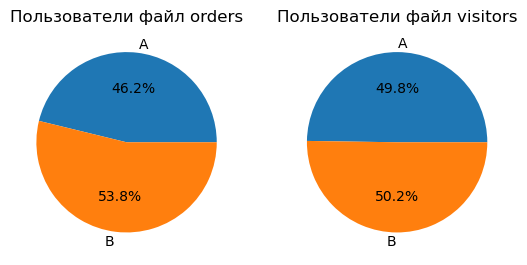

In [25]:
labels_group = ['A', 'B']

data1 = orders.groupby('group')['visitor_id'].nunique()
data2 = visitors.groupby('group')['visitors'].sum()

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(data1, labels = labels_group, autopct = '%1.1f%%')
ax1.set_title('Пользователи файл orders')
ax2.pie(data2, labels = labels_group, autopct = '%1.1f%%')
ax2.set_title('Пользователи файл visitors')

plt.show()

In [26]:
print('Group A orders (visitor_id):', orders[orders['group'] == 'A']['visitor_id'].count())
print('Group B orders (visitor_id)', orders[orders['group'] == 'B']['visitor_id'].count())
print('Difference B vs A (%):', (orders[orders['group'] == 'B']['visitor_id'].count()
                                 / orders[orders['group'] == 'A']['visitor_id'].count() -1).round(2))

Group A orders (visitor_id): 557
Group B orders (visitor_id) 640
Difference B vs A (%): 0.15


In [27]:
print('Group A visitors (visitors):', visitors[visitors['group'] == 'A']['visitors'].sum())
print('Group B visitors (visitors)', visitors[visitors['group'] == 'B']['visitors'].sum())
print('Difference B vs A (%):', (visitors[visitors['group'] == 'B']['visitors'].sum()
                                 / visitors[visitors['group'] == 'A']['visitors'].sum() -1).round(2))

Group A visitors (visitors): 18736
Group B visitors (visitors) 18916
Difference B vs A (%): 0.01


<div style="border:solid green 2px; padding: 20px">

Пользователи разделены практически на равные доли по группам А и В (по файлу visitors). Разница количества пользователей между группами 1%. Что является приемлемым.

Но разница долей пользователей, оформивших заказ, по группам уже больше: 7.6%.

</div>

### Проверка дубликатов пользователей в разных группах

<div style="border:solid black 2px; padding: 20px">
    
Проверим дубликаты пользователей в разных группах по файлу с заказами.

</div>

In [28]:
duplicates = np.intersect1d(orders.query('group == "A"')['visitor_id'], orders.query('group == "B"')['visitor_id'])

print('-'*50)
print('Количество дубликатов:', len(duplicates))
print('-'*50)

--------------------------------------------------
Количество дубликатов: 58
--------------------------------------------------


In [29]:
# Группируем пользователей по группам теста
id_dupl = orders.pivot_table(index=['group', 'visitor_id'] , values='revenue', aggfunc='sum').reset_index()

# Добавляем столбец для определения дубликатов пользователей по группам
id_dupl['boolean'] = id_dupl['visitor_id'].duplicated()
id_dupl.head()

,group,visitor_id,revenue,boolean
0,A,8300375,1790,False
1,A,11685486,6201,False
2,A,54447517,130,False
3,A,66685450,7990,False
4,A,78758296,1044,False


In [30]:
print('-'*50)
print('Дубликаты в группах теста:', id_dupl[id_dupl['boolean'] == True]['boolean'].count())
print('Уникальные пользователи в группах теста:', id_dupl[id_dupl['boolean'] == False]['boolean'].count())
print('Доля дубликатов:', (id_dupl[id_dupl['boolean'] == True]['boolean'].count() / id_dupl['boolean'].count()).round(3))
print('-'*50)

--------------------------------------------------
Дубликаты в группах теста: 58
Уникальные пользователи в группах теста: 1031
Доля дубликатов: 0.053
--------------------------------------------------


In [31]:
# проверяем группы у дубликатов по дням

orders.query('visitor_id in @duplicates')\
      .pivot_table(index=['visitor_id', 'group', 'date'], values='revenue', aggfunc='sum').head(15)

revenue
visitor_id group date               
8300375    A     2019-08-07     1790
           B     2019-08-01    10510
199603092  A     2019-08-12     6438
                 2019-08-15     3488
                 2019-08-22     6976
                 2019-08-27     2790
           B     2019-08-02     3488
232979603  A     2019-08-31       60
           B     2019-08-31     2640
237748145  A     2019-08-12      340
                 2019-08-15     1090
                 2019-08-20     1290
                 2019-08-27      470
           B     2019-08-15     7620
276558944  A     2019-08-12     5050

In [32]:
# создаем таблицу без дубликатов
orders_wo_dupl = orders[orders['visitor_id'].isin(duplicates) == False]

In [33]:
# проверка дубликатов после удаления
np.intersect1d(orders_wo_dupl.query('group == "A"')['visitor_id'], orders_wo_dupl.query('group == "B"')['visitor_id'])

array([], dtype=int64)

In [34]:
orders.pivot_table(index='group', values='visitor_id', aggfunc='nunique')\
      .rename(columns= {'visitor_id': 'Количество уникальных покупателей в группах исходный файл'})

,Количество уникальных покупателей в группах исходный файл
group,
A,503
B,586


In [35]:
orders_wo_dupl.pivot_table(index='group', values='visitor_id', aggfunc='nunique')\
            .rename(columns= {'visitor_id': 'Количество уникальных покупателей в группах после удаления дубликатов'})

,Количество уникальных покупателей в группах после удаления дубликатов
group,
A,445
B,528


<div style="border:solid green 2px; padding: 20px">

Есть дубликаты пользователей в файле с заказами в разных группах:
* 58 пользователей попали и в группу А и в группу В.
* Доля дубликатов пользователей 5.3%.
* Пользователь попадал в разные группы даже в один день. Необходимо уточнить у ответственного сотрудника, как происходило деление по группам, чтобы в дальнейшем понимать, как действовать с такой аномалией.

Как мы знаем, пользователи в группах должны быть уникальны для чистоты теста. Поэтому мы удалили дублирующихся пользователей для последующего анализа данных.


| group      | Количество уникальных покупателей в группах после удаления дубликатов   | 
|:-----------|:-----------------------------------------------------------------------:| 
|А           | 445                                                                     | 
|В           | 528                                                                     |  
|**TOTAL**   | **973**                                                                 |    



</div>

[Начало_проекта](#Начало_проекта)

<a id="анализ"></a>

## Анализ A/B-теста

### Объединение таблиц

<div style="border:solid black 2px; padding: 20px">
    
Объединим таблицы orders (без дубликатов) и visitors в одну.

</div>

In [36]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders_wo_dupl[np.logical_and(orders_wo_dupl['date'] <= x['date'],
                                                                             orders_wo_dupl['group'] == x['group'])]\
                              .agg({'date':'max','group':'max','transaction_id':'nunique',
                                    'visitor_id':'nunique','revenue':'sum'}), axis=1)\
                              .sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                         visitors['group'] == x['group'])]\
                                .agg({'date':'max','group':'max','visitors':'sum'}), axis=1)\
                                .sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [37]:
# сверка по датам, что совпадают максимальная и минальная дата.

print('cumulativeData минимальная дата:', cumulativeData['date'].min(),
      ', cumulativeData максимальная дата:', cumulativeData['date'].max())

print('visitors минимальная дата:', visitors['date'].min(),
         ', visitors максимальная дата:', visitors['date'].max())

print('orders минимальная дата:', orders_wo_dupl['date'].min(),
      ', orders максимальная дата:', orders_wo_dupl['date'].max())

cumulativeData минимальная дата: 2019-08-01 00:00:00 , cumulativeData максимальная дата: 2019-08-31 00:00:00
visitors минимальная дата: 2019-08-01 00:00:00 , visitors максимальная дата: 2019-08-31 00:00:00
orders минимальная дата: 2019-08-01 00:00:00 , orders максимальная дата: 2019-08-31 00:00:00


### Графики кумулятивных значений

#### График кумулятивной выручки по группам

<div style="border:solid black 2px; padding: 20px">
    
Построим графики кумулятивной выручки по дням и группам A/B-тестирования. 

</div>

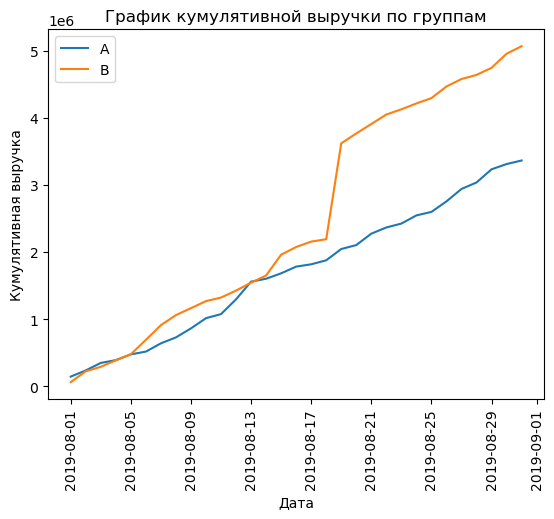

In [38]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=90)
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Кумулятивная выручка')
plt.xlabel('Дата')
plt.legend()
plt.show()

In [39]:
orders_wo_dupl.pivot_table(index='date', columns='group', values=['visitor_id', 'transaction_id', 'revenue'],
                           aggfunc={'visitor_id':'nunique', 'transaction_id' : 'nunique', 'revenue':'sum'})\
              .style.format("{:.1f}")\
              .background_gradient(cmap='Blues', axis=0)\
              .set_caption('Продажи, количество заказов, количество покупателей по дням в разрезе групп')

In [40]:
# кумулятивные данные по продажам группа 'B'
cumulativeData_cumulative = orders_wo_dupl[orders_wo_dupl['group'] == 'B']\
                            .pivot_table(index='date', columns='group', values= 'revenue', aggfunc='sum')\
                            .rename(columns= {'B': 'revenue_day'})
cumulativeData_cumulative['revenue_cumulative'] = cumulativeData_cumulative['revenue_day'].cumsum()
cumulativeData_cumulative.style.set_caption('Кумулятивные данные по продажам группы B')

group,revenue_day,revenue_cumulative
date,,
2019-08-01 00:00:00,59758,59758
2019-08-02 00:00:00,162043,221801
2019-08-03 00:00:00,67049,288850
2019-08-04 00:00:00,96890,385740
2019-08-05 00:00:00,89908,475648
2019-08-06 00:00:00,214842,690490
2019-08-07 00:00:00,219164,909654
2019-08-08 00:00:00,150141,1059795
2019-08-09 00:00:00,103166,1162961


In [41]:
# группа 'B' данные за "2019-08-19"
orders_wo_dupl.query('date == "2019-08-19" and group == "B"')\
              .pivot_table(index=['date', 'visitor_id', 'transaction_id'], values= 'revenue', aggfunc={'revenue':'sum'})\
              .reset_index().sort_values(by='revenue', ascending=False)\
              .style.set_caption('Данные по продажам группы B за 2019-08-19')

,date,visitor_id,transaction_id,revenue
7,2019-08-19 00:00:00,1920142716,590470918,1294500
18,2019-08-19 00:00:00,2837914161,1570513684,33405
0,2019-08-19 00:00:00,154576532,2683113224,26550
14,2019-08-19 00:00:00,2536252163,3268879337,20026
2,2019-08-19 00:00:00,290022471,4170537404,16480
4,2019-08-19 00:00:00,990904712,4161654914,11249
3,2019-08-19 00:00:00,522292794,1739748874,4880
19,2019-08-19 00:00:00,3860669668,1033377712,3990
8,2019-08-19 00:00:00,2075769885,90109939,3525
11,2019-08-19 00:00:00,2397843657,19467429,2630


In [42]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups_590470918 = orders[['date','group']].drop_duplicates()

orders_wo_dupl_590470918 = orders_wo_dupl[orders_wo_dupl['transaction_id'] != 590470918]

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated_590470918 = datesGroups_590470918.apply(lambda x: orders_wo_dupl_590470918[np.logical_and(
                               orders_wo_dupl_590470918['date'] <= x['date'], orders_wo_dupl_590470918['group'] == x['group'])]\
                              .agg({'date':'max', 'group':'max', 'transaction_id':'nunique',
                                    'visitor_id':'nunique', 'revenue':'sum'}), axis=1)\
                              .sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated_590470918 = datesGroups_590470918.apply(lambda x: visitors[np.logical_and(
                                 visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1)\
                                .sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData_590470918 = ordersAggregated_590470918.merge(visitorsAggregated_590470918,
                                                            left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData_590470918.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData_590470918.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


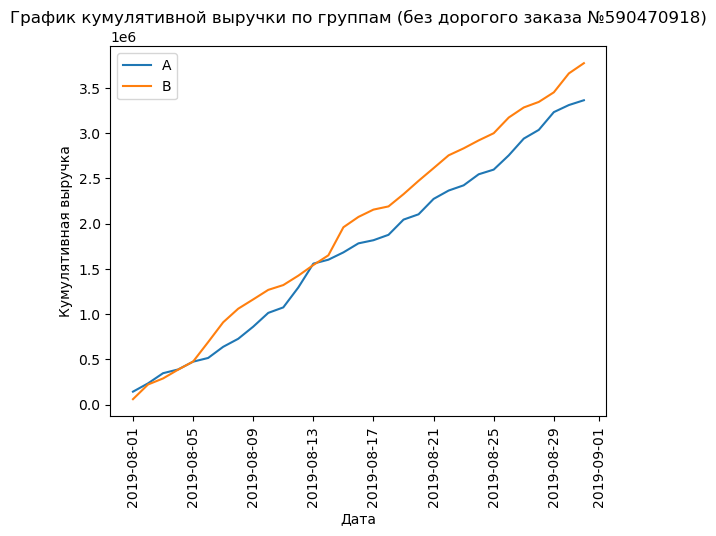

In [43]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA_590470918 = cumulativeData_590470918[cumulativeData_590470918['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB_590470918 = cumulativeData_590470918[cumulativeData_590470918['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA_590470918['date'], cumulativeRevenueA_590470918['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB_590470918['date'], cumulativeRevenueB_590470918['revenue'], label='B')

plt.xticks(rotation=90)
plt.title('График кумулятивной выручки по группам (без дорогого заказа №590470918)')
plt.ylabel('Кумулятивная выручка')
plt.xlabel('Дата')
plt.legend()
plt.show()

<div style="border:solid green 2px; padding: 20px">

Выручка почти равномерно увеличивается в течение всего теста. 

Однако выручка группы 'В' 19.08.2019 резко выросла (с 2.2 млн. у.е. до 3.6 млн. у.е.):
* Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.
* Судя по таблице выше в нашем случае это вероятно влияние дорогих заказов 19.08.2019, когда сумма заказов за один день составила 1.4 млн. у.е., что выше средней выручки остальных дней группы 'В' почти в 12 раз.
* Проверили заказы 19.08.2019, видим один заказ № 590470918 стоимостью 1294500 у.е., этот заказ можно считать выбросом.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы видим, что уже со второй половины периода кумулятивная выручка группы 'В' стабильно выше значений группы 'А'.

</div>

#### График кумулятивного среднего чека по группам

<div style="border:solid black 2px; padding: 20px">
    
Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов.

</div>

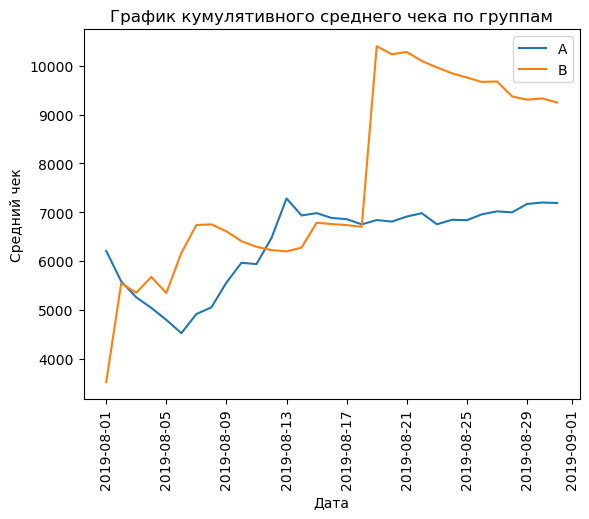

In [44]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=90)
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.show()

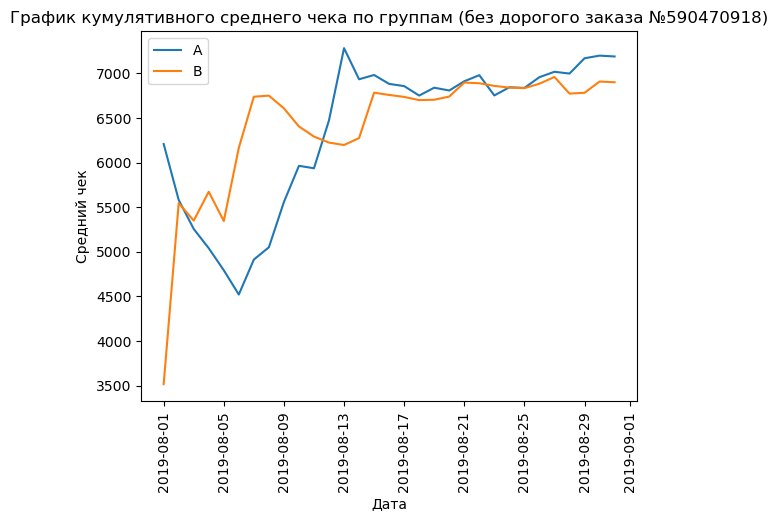

In [45]:
plt.plot(cumulativeRevenueA_590470918['date'],
         cumulativeRevenueA_590470918['revenue']/cumulativeRevenueA_590470918['orders'], label='A')
plt.plot(cumulativeRevenueB_590470918['date'],
         cumulativeRevenueB_590470918['revenue']/cumulativeRevenueB_590470918['orders'], label='B')
plt.xticks(rotation=90)
plt.title('График кумулятивного среднего чека по группам (без дорогого заказа №590470918)')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.show()

<div style="border:solid green 2px; padding: 20px">

По графику видим аналогичную картину, как в предыдущем пункте. Кумулятивный средний чек группы 'В' вырос 19.08.2019. Как мы выяснили ранее, это связано с одним заказом № 590470918 в группе 'В'.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы видим, что вначале периода есть колебания по среднему чеку, но ближе к концу теста средний чек становится более равномерным, и находится в одном диапазоне для обеих групп (в районе 7000 у.е.).

</div>

#### График относительного изменения кумулятивного среднего чека группы B к группе A

<div style="border:solid black 2px; padding: 20px">
    
Построим график относительного различия для среднего чека. Добавим горизонтальную ось на уровне 0.

</div>

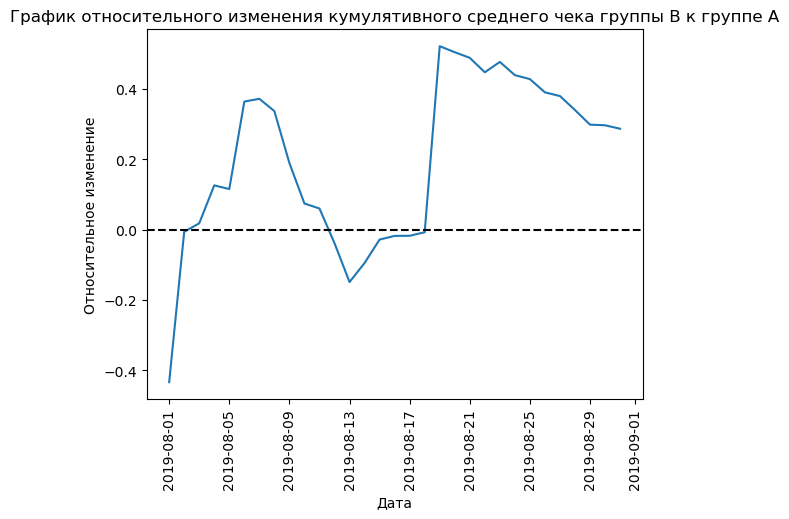

In [46]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Относительное изменение')
plt.xlabel('Дата')
plt.show()

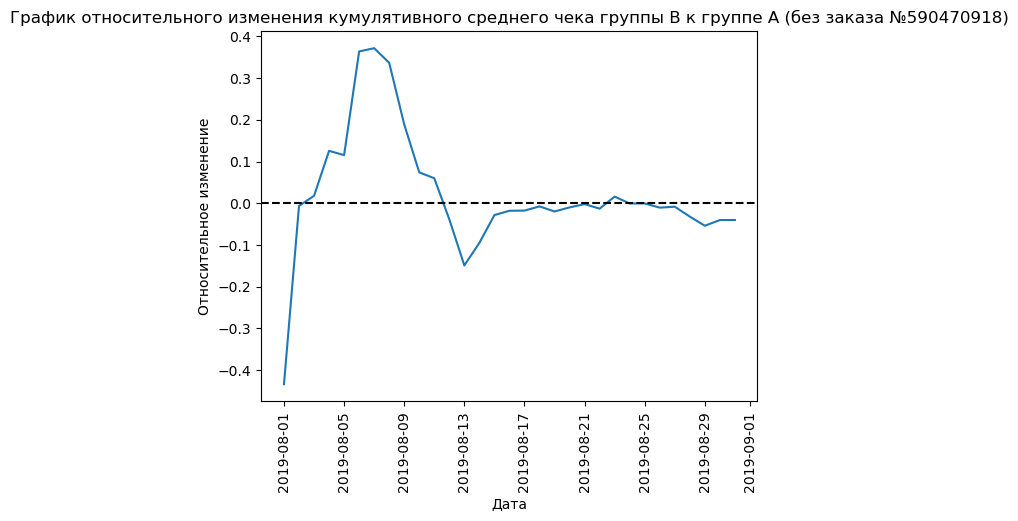

In [47]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue_590470918 = cumulativeRevenueA_590470918.merge(cumulativeRevenueB_590470918,
                                    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue_590470918['date'],
         (mergedCumulativeRevenue_590470918['revenueB']/mergedCumulativeRevenue_590470918['ordersB'])
         /(mergedCumulativeRevenue_590470918['revenueA']/mergedCumulativeRevenue_590470918['ordersA']) - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A (без заказа №590470918)')
plt.ylabel('Относительное изменение')
plt.xlabel('Дата')
plt.show()

<div style="border:solid green 2px; padding: 20px">

В нескольких точках график различия между сегментами резко «скачет». В данных точках мы наблюдали крупные заказы и выбросы на графике 'кумулятивный средний чек по группам'.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы наблюдаем то, что во второй половине теста нет значительных колебаний среднего чека по группам.

Всплеск в районе 6-9 августа можно объяснить не высоким средним чеком группы 'В', а скорее низкими показателями по среднему чеку группы 'А' в этот период.

</div>

####  График кумулятивного среднего количества заказов на посетителя по группам

<div style="border:solid black 2px; padding: 20px">
    
Проанализируем график кумулятивного среднего количества заказов на посетителя по группам. Зададим масштаб осей.

</div>

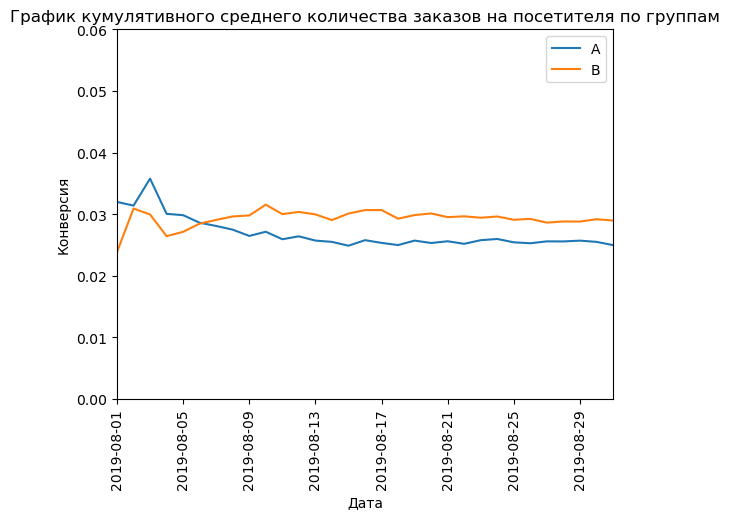

In [48]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=90)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.ylabel('Конверсия')
plt.xlabel('Дата')

# задаем масштаб осей
plt.axis([np.datetime64('2019-08-01'), np.datetime64('2019-08-31'), 0, 0.06]) 
plt.show()

<div style="border:solid green 2px; padding: 20px">

Группы колебались в начале периода, но примерно с 06.08.2019 конверсия группы 'В' стала стабильно выше конверсии группы 'А'.

</div>

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

<div style="border:solid black 2px; padding: 20px">
    
Построим график изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

</div>

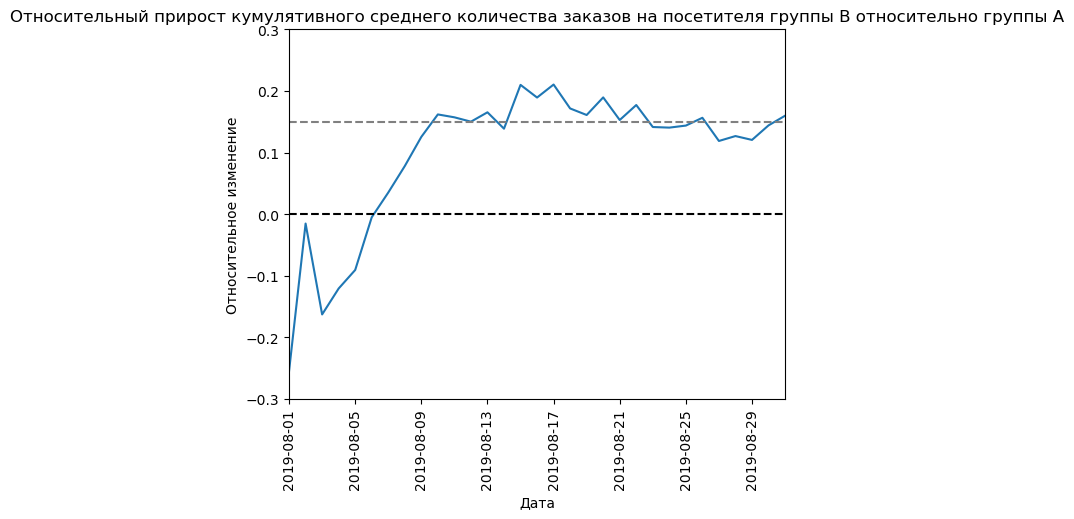

In [49]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
                              cumulativeDataB[['date','conversion']],
                              left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA'] - 1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([np.datetime64('2019-08-01'), np.datetime64('2019-08-31'), -0.3, 0.3])
plt.title('Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A')
plt.xticks(rotation=90)
plt.ylabel('Относительное изменение')
plt.xlabel('Дата')
plt.show()

<div style="border:solid green 2px; padding: 20px">

В начале теста группа 'B' значительно проигрывала группе 'A' по конверсии, затем вырвалась вперёд и зафиксировалась на одном уровне (относительный прирост примерно 15%).

</div>

#### Вывод

<div style="border:solid green 2px; padding: 20px">

**Графики кумулятивных значений.**

**Кумулятивная выручка.**

Выручка почти равномерно увеличивается в течение всего теста. 

Однако выручка группы 'В' 19.08.2019 резко выросла (с 2.2 млн. у.е. до 3.6 млн. у.е.):
* Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.
* Судя по таблице выше в нашем случае это вероятно влияние дорогих заказов 19.08.2019, когда сумма заказов за один день составила 1.4 млн. у.е., что выше средней выручки остальных дней группы 'В' почти в 12 раз.
* Проверили заказы 19.08.2019, видим один заказ № 590470918 стоимостью 1294500 у.е., этот заказ можно считать выбросом.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы видим, что уже со второй половины периода кумулятивная выручка группы 'В' стабильно выше значений группы 'А'.

**Кумулятивный средний чек по группам.**

По графику видим аналогичную картину, как в предыдущем пункте. Кумулятивный средний чек группы 'В' вырос 19.08.2019. Как мы выяснили ранее, это связано с одним заказом № 590470918 в группе 'В'.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы видим, что вначале периода есть колебания по среднему чеку, но ближе к концу теста средний чек становится более равномерным. И одном диапазоне для обеих групп (в районе 7000 у.е.)

**Относительное изменение кумулятивного среднего чека группы B к группе A.**

В нескольких точках график различия между сегментами резко «скачет». В данных точках мы наблюдали крупные заказы и выбросы на графике 'кумулятивный средний чек по группам'.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы наблюдаем то, что во второй половине теста нет значительных колебаний среднего чека по группам.

Всплеск в районе 6-9 августа можно объяснить не высоким средним чекам группы 'В', а скорее низкими показателями по среднему чеку группы 'А' в этот период.

**Кумулятивное среднее количество заказов на посетителя по группам.**

Группы колебались в начале периода, но примерно с 06.08.2019 конверсия группы 'В' стала стабильно выше конверсии группы 'А'.

**Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A.**

В начале теста группа 'B' значительно проигрывала группе 'A' по конверсии, затем вырвалась вперёд и зафиксировалась на одном уровне (относительный прирост примерно 15%).

</div>

### Точечные графики и перцентили

#### Точечный график количества заказов по пользователям

<div style="border:solid black 2px; padding: 20px">
    
Построим точечный график количества заказов по пользователям.

Зачастую «обычный» пользователь совершает не больше двух заказов за короткий срок, проверим полученные данные.

</div>

In [50]:
# данные без дубликатов пользователей в группах
ordersByUsers = orders_wo_dupl.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
ordersByUsers.columns = ['visitor_id_wo_duplicated', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)\
             .style.set_caption('Количество заказов по пользователям (без дубликатов)')

,visitor_id_wo_duplicated,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


In [51]:
# данные исходник
ordersByUsers_source = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
ordersByUsers_source.columns = ['visitor_id', 'orders']
ordersByUsers_source.sort_values(by='orders', ascending=False).head(10)\
                     .style.set_caption('Количество заказов по пользователям (исходный файл)')

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


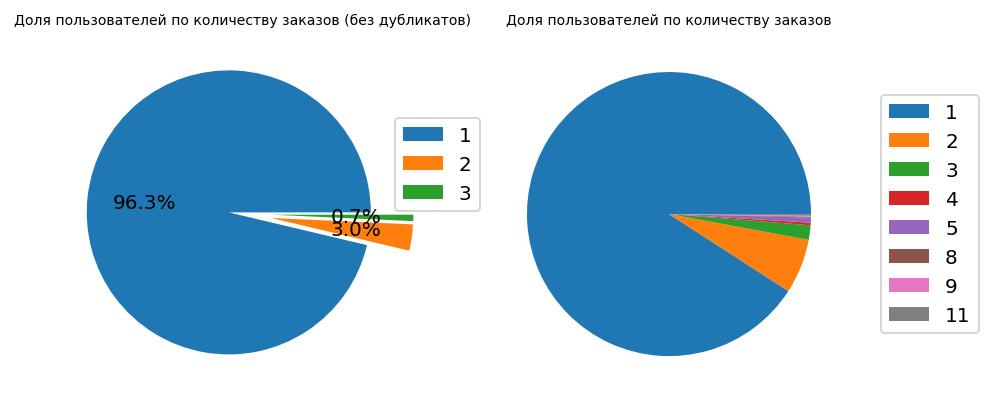

In [52]:
var1 = ordersByUsers.groupby('orders')['visitor_id_wo_duplicated'].count()
var2 = ordersByUsers_source.groupby('orders')['visitor_id'].count()

label_ax1 = [1,2,3]
label_ax2 = [1,2,3,4,5,8,9,11]

explode_ax1 = [0.1,0.2,0.2]

fig = plt.figure(figsize=(7,7),dpi=144)
ax1 = fig.add_subplot(121)
ax1.pie(var1, explode=explode_ax1, autopct='%.1f%%')
ax1.legend(label_ax1, bbox_to_anchor=(0.9, 0.8))
ax1.set_title('Доля пользователей по количеству заказов (без дубликатов)', fontsize=7)

ax2 = fig.add_subplot(122)
ax2.pie(var2)
ax2.legend(label_ax2, loc='right', bbox_to_anchor=(1.4, 0.5))
ax2.set_title('Доля пользователей по количеству заказов', fontsize=7)

plt.show()

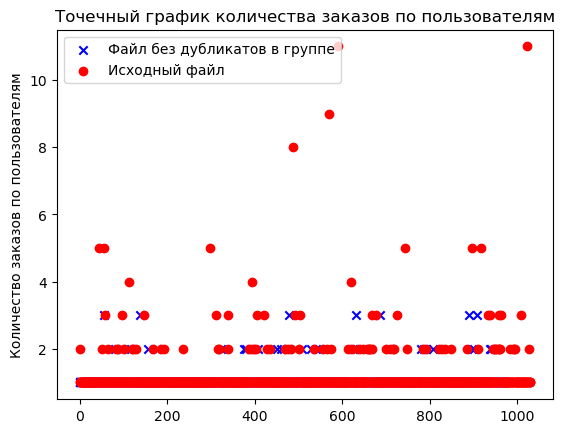

In [53]:
# строим диаграмму рассеяния для двух таблиц
x1_orders = pd.Series(range(0,len(ordersByUsers)))
y1_orders = ordersByUsers['orders']

x2_orders = pd.Series(range(0,len(ordersByUsers_source)))
y2_orders = ordersByUsers_source['orders']

plt.scatter(x1_orders, y1_orders, c = 'b', marker = 'x', label='Файл без дубликатов в группе')
plt.scatter(x2_orders, y2_orders, c = 'r', marker = 'o', label='Исходный файл')
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов по пользователям')
plt.legend(loc='upper left')
plt.show()

<div style="border:solid green 2px; padding: 20px">

Выборка без дубликатов пользователей по группам:
* Только 7 пользователей совершили 3 заказа за август 2019, остальные меньше трех.
* У большинства пользователей 1 заказ (доля 96.3%).

Исходник (есть дубликаты пользователей по группам):
* У большинства пользователей 1 заказ (доля 90.9%).
* У 6.2% пользователей 2 заказа.
* Доля 2.9% - где больше трех заказов у пользователя.

</div>

#### 95-й и 99-й перцентили количества заказов на пользователя

<div style="border:solid black 2px; padding: 20px">
    
Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

Выберем границу для определения аномальных пользователей.

</div>

In [54]:
print('Перцентили (95, 99) количества заказов на одного пользователя (данные без дубликатов):',
      np.percentile(ordersByUsers['orders'], [95, 99]))

Перцентили (95, 99) количества заказов на одного пользователя (данные без дубликатов): [1. 2.]


In [55]:
print('Перцентили (95, 99) количества заказов на одного пользователя (исходник):',
      np.percentile(ordersByUsers_source['orders'], [95, 99]))

Перцентили (95, 99) количества заказов на одного пользователя (исходник): [2. 4.]


<div style="border:solid green 2px; padding: 20px">

Посчитав перцентили (95 и 99) количества заказов на пользователя для двух таблиц (с дубликатами и без дубликатов), будем предполагать, что можно выбрать от 3х заказов на пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

</div>

#### Точечный график стоимостей заказов

<div style="border:solid black 2px; padding: 20px">
    
Построим точечный график стоимостей заказов.

</div>

In [56]:
# данные без дубликатов пользователей в группах
ordersByUsers_revenue = orders_wo_dupl.groupby('transaction_id', as_index=False).agg({'revenue': 'sum'})
ordersByUsers_revenue.sort_values(by='revenue', ascending=False).head(10)\
                     .style.set_caption('Стоимость заказов (без дубликатов)')

,transaction_id,revenue
143,590470918,1294500
939,3936777065,202740
161,666610489,92550
875,3668308183,86620
850,3603576309,67990
311,1348774318,66350
71,316924019,65710
310,1347999392,60450
585,2420050534,58550
738,3163614039,53904


In [57]:
# данные исходник
ordersByUsers_source_revenue = orders.groupby('transaction_id', as_index=False).agg({'revenue': 'sum'})
ordersByUsers_source_revenue.sort_values(by='revenue', ascending=False).head(10)\
                            .style.set_caption('Стоимость заказов (исходный файл)')

,transaction_id,revenue
168,590470918,1294500
1107,3936777065,202740
49,192721366,93940
188,666610489,92550
1029,3668308183,86620
322,1216533772,78990
503,1811671147,78990
1000,3603576309,67990
364,1348774318,66350
81,316924019,65710


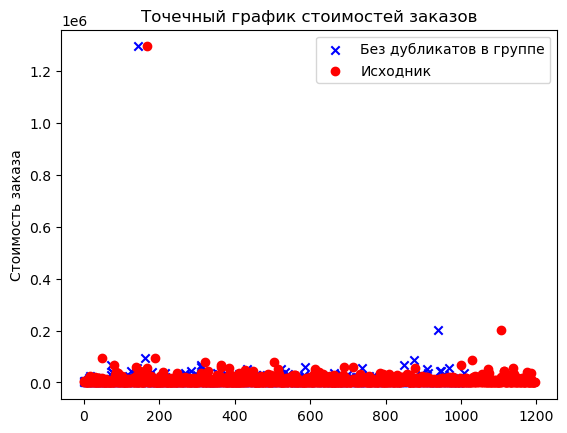

In [58]:
# строим диаграмму рассеяния для двух таблиц
x1 = pd.Series(range(0,len(ordersByUsers_revenue['revenue'])))
y1 = ordersByUsers_revenue['revenue']

x2 = pd.Series(range(0,len(ordersByUsers_source_revenue['revenue'])))
y2 = ordersByUsers_source_revenue['revenue']

plt.scatter(x1, y1, c = 'b', marker = 'x', label='Без дубликатов в группе')
plt.scatter(x2, y2, c = 'r', marker = 'o', label='Исходник')
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.legend(loc='upper right')
plt.show()

<div style="border:solid green 2px; padding: 20px">

Есть немного дорогих заказов. По графику предположительно можно выбрать границу аномальных заказов до 50 000 у.е. Однако ниже посчитаем перцентили, что точно отсеять крайние значения. 

</div>

#### 95-й и 99-й перцентили стоимости заказов

<div style="border:solid black 2px; padding: 20px">
    
Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

</div>

In [59]:
print('Перцентили (95, 99) стоимости заказов (данные без дубликатов):',
      np.percentile(ordersByUsers_revenue['revenue'], [95, 99]))

Перцентили (95, 99) стоимости заказов (данные без дубликатов): [26785. 53904.]


In [60]:
print('Перцентили (95, 99) стоимости заказов (исходник):',
      np.percentile(ordersByUsers_source_revenue['revenue'], [95, 99]))

Перцентили (95, 99) стоимости заказов (исходник): [28000.  58233.2]


<div style="border:solid green 2px; padding: 20px">

Границы у двух выборок схожи.

Будем смотреть по таблице без дубликатов пользователей.

Не более 5% заказов дороже 26 785 у.е. и не более 1% дороже 53 904 у.е.

</div>

#### Вывод

<div style="border:solid green 2px; padding: 20px">

**Проверка аномальных значений.**

**Количество заказов на пользователя.**

Выборка без дубликатов пользователей по группам:
* Только 7 пользователей совершили 3 заказа за август 2019, остальные меньше трех.
* У большинства пользователей 1 заказ (доля 96.3%).

Исходник (есть дубликаты пользователей по группам):
* У большинства пользователей 1 заказ (доля 90.9%).
* У 6.2% пользователей 2 заказа.
* Доля 2.9%  - где больше трех заказов у пользователя.

Посчитав перцентили (95 и 99) количества заказов на пользователя для двух таблиц (с дубликатами и без дубликатов), будем предполагать, что можно выбрать от 3х заказов на пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

**Стоимость заказов.**

По таблице без дубликатов пользователей: не более 5% заказов дороже 26 785 у.е. и не более 1% дороже 53 904 у.е.

</div>

### Статистическая значимость различий

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

<div style="border:solid black 2px; padding: 20px">
    
Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Возьмем данные без дубликатов пользователей в группах А и В.

</div>

<div style="border:solid black 2px; padding: 20px">
    
Сформулируем гипотезы:
* Нулевая: различий в среднем количестве заказов между группами нет.
* Альтернативная: различия в среднем количестве заказов между группами есть.

Применим статистический критерий Манна-Уитни к полученным выборкам. 

</div>

In [61]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

data = visitorsADaily.merge(visitorsBDaily, left_on='date', right_on='date')

data.head()

,date,visitorsPerDateA,visitorsPerDateB
0,2019-08-01,719,713
1,2019-08-02,619,581
2,2019-08-03,507,509
3,2019-08-04,717,770
4,2019-08-05,756,707


In [62]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitor_id', 'orders'].
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = (
    orders_wo_dupl[orders_wo_dupl['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders_wo_dupl[orders_wo_dupl['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

In [63]:
# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов.
# Тем, кто ничего не заказал, будут соответствовать нули.

sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                               name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                               name='orders')],axis=0) 

In [64]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительный прирост среднего числа заказов группы B:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Относительный прирост среднего числа заказов группы B: 0.160


<div style="border:solid green 2px; padding: 20px">

По «сырым» данным различия в среднем числе заказов групп A и B есть.
*  p-value =0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.
* Относительный прирост группы B равен 16%.

</div>

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

<div style="border:solid black 2px; padding: 20px">
    
Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Возьмем данные без дубликатов пользователей в группах А и В.

</div>

<div style="border:solid black 2px; padding: 20px">
    
Сформулируем гипотезы:
* Нулевая гипотеза: различий в среднем чеке между группами нет.
* Альтернативная гипотеза: различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 

</div>

In [65]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(
    orders_wo_dupl[orders_wo_dupl['group']=='A']['revenue'],
    orders_wo_dupl[orders_wo_dupl['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B:','{0:.3f}'.format(
    orders_wo_dupl[orders_wo_dupl['group']=='B']['revenue'].mean()
    /orders_wo_dupl[orders_wo_dupl['group']=='A']['revenue'].mean()-1)) 

p-value: 0.829
Относительный прирост среднего чека группы B: 0.287


<div style="border:solid green 2px; padding: 20px">

По «сырым» данным различий в среднем чеке заказа между группами нет.
*  p-value =0.829 больше 0.05. P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
* При этом относительный прирост группы B равен 28.7%.

</div>

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

<div style="border:solid black 2px; padding: 20px">
    
Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Возьмем данные без дубликатов пользователей в группах А и В.

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 53904 — usersWithExpensiveOrders. 

</div>

<div style="border:solid black 2px; padding: 20px">
    
Сформулируем гипотезы:
* Нулевая: различий в среднем количестве заказов между группами нет.
* Альтернативная: различия в среднем количестве заказов между группами есть.

Применим статистический критерий Манна-Уитни к полученным выборкам. 

</div>

In [66]:
print('percentile99_orders', np.percentile(ordersByUsers['orders'], 99))
print('percentile99_revenue', np.percentile(ordersByUsers_revenue['revenue'], 99))

percentile99_orders 2.0
percentile99_revenue 53904.0


In [67]:
# Узнаем, сколько всего аномальных пользователей атрибутом shape

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 99)]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 99)]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = (orders_wo_dupl[orders_wo_dupl['revenue'] > np.percentile(ordersByUsers_revenue['revenue'], 99)]\
                            ['visitor_id'])

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())
print(abnormalUsers.shape[0]) 

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitor_id, dtype: int64
16


In [68]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),name='orders'),
    ],axis=0)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),name='orders'),
    ],axis=0) 

In [69]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего числа заказов группы B:',"{0:.3f}".format(sampleBFiltered.mean()
                                                                                / sampleAFiltered.mean() - 1))

p-value: 0.007
Относительный прирост среднего числа заказов группы B: 0.189


<div style="border:solid green 2px; padding: 20px">

Результаты по среднему количеству заказов практически не изменились. Предполагаем, различия в среднем числе заказов групп A и B есть.

По «сырым» данным:
* p-value =0.011 меньше 0.05
* Относительный прирост группы B равен 16%.

По «очищенным» данным:
* p-value =0.007 меньше 0.05
* Относительный прирост группы B равен 18.9%.

</div>

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

<div style="border:solid black 2px; padding: 20px">
    
Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Возьмем данные без дубликатов пользователей в группах А и В.

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 53904 — usersWithExpensiveOrders. 

</div>

<div style="border:solid black 2px; padding: 20px">
    
Сформулируем гипотезы:
* Нулевая гипотеза: различий в среднем чеке между группами нет.
* Альтернативная гипотеза: различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 

</div>

In [70]:
print('p-value:',
    '{0:.3f}'.format(stats.mannwhitneyu(orders_wo_dupl[np.logical_and(orders_wo_dupl['group'] == 'A',
     np.logical_not(orders_wo_dupl['visitor_id'].isin(abnormalUsers)))]['revenue'],
     orders_wo_dupl[np.logical_and(orders_wo_dupl['group'] == 'B',
     np.logical_not(orders_wo_dupl['visitor_id'].isin(abnormalUsers)),)]['revenue'])[1])
     )

print('Относительный прирост среднего чека группы B:',
    "{0:.3f}".format(orders_wo_dupl[np.logical_and(orders_wo_dupl['group'] == 'B',
     np.logical_not(orders_wo_dupl['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()
     / orders_wo_dupl[np.logical_and(orders_wo_dupl['group'] == 'A',
     np.logical_not(orders_wo_dupl['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()- 1)
     ) 

p-value: 0.788
Относительный прирост среднего чека группы B: -0.032


<div style="border:solid green 2px; padding: 20px">

Результаты по среднему чеку практически не изменились. Предполагаем, различий по среднему чеку групп A и B нет.

Результаты по «очищенным» данным:

* P-value уменьшился (с 0.829 до 0.788). P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
* Разница между сегментами сократилась с 28.7% («сырые» данные) до -3.2% («очищенные» данные).

</div>

#### Решение по результатам теста

<div style="border:solid green 2px; padding: 20px">

Имеющиеся факты:
* Есть статистически значимые различия по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий. Относительный прирост группы 'B' равен 18.9% (по «очищенным» данным).
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Средний чек группы 'B' ниже среднего чека группы 'A' -3.2% (по «очищенным» данным).
* График различия среднего количества заказов между группами сообщает, что результаты группы 'B' лучше группы 'A' (примерно на 15% зафиксировались данные в конце периода).
* График различия среднего чека (без аномально дорогого заказа 19.08.2019) говорит о том, что результаты обеих групп во второй половине периода теста были практически на одном уровне.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Мы видим значительно лучшие показатели по конверсии у группы 'В'.

</div>

[Начало_проекта](#Начало_проекта)

<a id="итоги"></a>

## Итоги исследования

<div style="border:solid blue 2px; padding: 20px">

Путем исследования данных о визитах и продажах нашего интернет-магазина, мы достигли целей нашего проекта.
* Приоритизировали гипотезы (подготовленные совместно с отделом маркетинга для увеличения выручки).
* Проанализировали графики кумулятивных данных.
* Запустили A/B-тест.
* Проанализировали результаты A/B-теста.
* Приняли решение по результатам теста.

***  
<span style="color:green;font-weight:700;font-size:15px">**Приоритизация гипотез.**</span>
***

Сделали приоритизации гипотез фреймворком ICE и фреймворком RICE. Всего было 9 гипотез.

Результаты приоритизаций различаются. Когда мы делали приоритизации способом ICE, имели большое влияние высокие оценки параметров impact и confidence. А при приоритизации способом RICE высокие оценки параметра reach (охват пользователей) изменили порядок приоритизации. Получается, когда важно учесть охват пользователей при приоритизации гипотез, используем фреймворк RICE.

Две гипотезы, которые попали в топ по приоритизации и ICE и RICE:
* **(7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**
* **(0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**

Обратить внимание на гипотезу **(8) Запустить акцию, дающую скидку на товар в день рождения**. Топ-1 по приоритизации способом ICE. По охвату пользователей самая низкая оценка. Но важно понимать, что это значимая активность с точки зрения лояльности клиента, которая влияет на формирование долгосрочного позитивного отношения клиента к бренду. Поэтому эту гипотезу надо отнести к важным, но не срочным.

А также обратить внимание на гипотезу **(2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа**. Топ-2 по приоритизации способом RICE. Так как предполагается, что данное обновление имеет прямое влияние на количество штук в чеке, соответственно и на средний чек, и как итог общую выручку, то стоит отнести к важным, но не срочным.

***  
<span style="color:green;font-weight:700;font-size:15px">**Количество пользователей в группах теста и дубликаты покупателей в группах теста.**</span>
***

Пользователи разделены практически на равные доли по группам А и В (по файлу visitors). Разница долей между группами 1%. Что является приемлемым. Но разница долей пользователей, оформивших заказ, по группам уже больше: 7.6%.

Есть дубликаты пользователей в файле с заказами в разных группах:
* 58 пользователей попали и в группу А и в группу В.
* Доля дубликатов пользователей 5.3%, доля продаж данных пользователей 8.4%.
* Пользователь попадал в разные группы даже в один день. Необходимо уточнить у ответственного сотрудника, как происходило деление по группам, чтобы в дальнейшем понимать, как действовать с такой аномалией.

Как мы знаем, пользователи в группах должны быть уникальны для чистоты теста. Поэтому мы удалили дублирующихся пользователей для последующего анализа данных.

| group      | Количество уникальных покупателей в группах после удаления дубликатов   | 
|:-----------|:-----------------------------------------------------------------------:| 
|А           | 445                                                                     | 
|В           | 528                                                                     |  
|**TOTAL**   | **973**                                                                 |  


***  
<span style="color:green;font-weight:700;font-size:15px">**Графики кумулятивных значений.**</span>
***

**Кумулятивная выручка.**

Выручка почти равномерно увеличивается в течение всего теста. 

Однако выручка группы 'В' 19.08.2019 резко выросла (с 2.2 млн. у.е. до 3.6 млн. у.е.):
* Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.
* Судя по таблице выше в нашем случае это вероятно влияние дорогих заказов 19.08.2019, когда сумма заказов за один день составила 1.4 млн. у.е., что выше средней выручки остальных дней группы 'В' почти в 12 раз.
* Проверили заказы 19.08.2019, видим один заказ № 590470918 стоимостью 1294500 у.е., этот заказ можно считать выбросом.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы видим, что уже со второй половины периода кумулятивная выручка группы 'В' стабильно выше значений группы 'А'.

**Кумулятивный средний чек по группам.**

По графику видим аналогичную картину, как в предыдущем пункте. Кумулятивный средний чек группы 'В' вырос 19.08.2019. Как мы выяснили ранее, это связано с одним заказом № 590470918 в группе 'В'.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы видим, что вначале периода есть колебания по среднему чеку, но ближе к концу теста средний чек становится более равномерным, и находится в одном диапазоне для обеих групп (в районе 7000 у.е.)

**Относительное изменение кумулятивного среднего чека группы B к группе A.**

В нескольких точках график различия между сегментами резко «скачет». В данных точках мы наблюдали крупные заказы и выбросы на графике кумулятивный средний чек по группам.

Убрав аномальный заказ № 590470918 стоимостью 1294500 у.е., мы наблюдаем то, что во второй половине теста нет значительных колебаний среднего чека по группам.

Всплеск в районе 6-9 августа можно объяснить не высоким средним чекам группы 'В', а скорее низкими показателями по среднему чеку группы 'А' в этот период.

**Кумулятивное среднее количество заказов на посетителя по группам.**

Группы колебались в начале периода, но примерно с 06.08.2019 конверсия группы 'В' стала стабильно выше конверсии группы 'А'.

**Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A.**

В начале теста по конверсии группа B значительно проигрывала группе A, затем вырвалась вперёд и зафиксировалась на одном уровне (относительный прирост примерно 15%).

***  
<span style="color:green;font-weight:700;font-size:15px">**Проверка аномальных значений.**</span>
***

**Количество заказов на пользователя.**

Выборка без дубликатов пользователей по группам:
* Только 7 пользователей совершили 3 заказа за август 2019, остальные меньше трех.
* У большинства пользователей 1 заказ (доля 96.3%).

Исходник (есть дубликаты пользователей по группам):
* У большинства пользователей 1 заказ (доля 90.9%).
* У 6.2% пользователей 2 заказа, доля 2.9% где больше трех заказов у пользователя.

Посчитав перцентили (95 и 99) количества заказов на пользователя для двух таблиц (с дубликатами и без дубликатов), будем предполагать, что можно выбрать от 3х заказов на пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

**Стоимость заказов.**

По таблице без дубликатов пользователей: не более 5% заказов дороже 26 785 у.е. и не более 1% дороже 53 904 у.е.

***  
<span style="color:green;font-weight:700;font-size:15px">**Решение по результатам теста.**</span>
***

Имеющиеся факты:
* Есть статистически значимые различия по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий. Относительный прирост группы 'B' равен 18.9% (по «очищенным» данным).
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Средний чек группы 'B' ниже среднего чека группы 'A' -3.2% (по «очищенным» данным).
* График различия среднего количества заказов между группами сообщает, что результаты группы 'B' лучше группы 'A' (примерно на 15% зафиксировались данные в конце периода).
* График различия среднего чека (без аномально дорогого заказа 19.08.2019) говорит о том, что результаты обеих групп во второй половине периода теста были практически на одном уровне.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Мы видим значительно лучшие показатели по конверсии у группы 'В'. У группы 'В' увеличилась конверсия, средний чек у обеих групп был на одном уровне, в следствии этого мы получили дополнительную выручку у группы 'В'.

</div>